# MNIST with GAN

prepare dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
batch_size = 128
image_size = 28*28

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)) #normalize between -1 and 1
]
)

In [8]:
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024), #input=imagesize, 1024=neuronsize
            nn.LeakyReLU(0.2), #slope parameter
            nn.Linear(1024,512), #input=output of first 512 is hyperparemeter
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1), #output layer 1 output real or fake detection
            nn.Sigmoid()
        )

    def forward(self, img):
      return self.model(img.view(-1,image_size)) #flatten the image and give it to the model

generator

In [12]:
class Generator(nn.Module):
  def __init__(self, z_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,image_size), #1024 to 784 (28*28)
        nn.Tanh() #output activation function
    )

  def forward(self, x):
    return self.model(x).view(-1,1,28,28)

GAN model training

In [16]:
lr = 0.0002
z_dim = 100 #random noise vector
epochs = 20

generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
g_optim = optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
d_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

for epoch in range(epochs):
  for i, (real_imgs,_) in enumerate(dataLoader):
    real_imgs = real_imgs.to(device)
    batch_size = real_imgs.size(0)
    real_labels = torch.ones(batch_size,1).to(device) #real images labeled as 1
    fake_labels = torch.zeros(batch_size,1).to(device) #fake images labeled as 0

    z = torch.randn(batch_size, z_dim).to(device) #generate random noise
    fake_imgs = generator(z) #generate fake image with generator

    real_loss = criterion(discriminator(real_imgs), real_labels) #calculate loss for real images
    fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels) #calculate loss for fake images
    d_loss = real_loss + fake_loss #total loss

    d_optim.zero_grad() #reset gradients
    d_loss.backward() #calculate gradients
    d_optim.step() #update weights

    g_loss = criterion(discriminator(fake_imgs), real_labels) #calculate loss for generator
    g_optim.zero_grad() #reset gradients
    g_loss.backward() #calculate gradients
    g_optim.step()

  print(f"Epoch {epoch+1}/{epochs} d_loss: {d_loss.item():.3f}, g_loss: {g_loss.item():.3f}")

Epoch 1/20 d_loss: 0.833, g_loss: 1.849
Epoch 2/20 d_loss: 0.236, g_loss: 3.249
Epoch 3/20 d_loss: 0.139, g_loss: 4.594
Epoch 4/20 d_loss: 0.289, g_loss: 4.412
Epoch 5/20 d_loss: 0.408, g_loss: 3.770
Epoch 6/20 d_loss: 0.364, g_loss: 2.437
Epoch 7/20 d_loss: 1.093, g_loss: 2.654
Epoch 8/20 d_loss: 0.442, g_loss: 2.074
Epoch 9/20 d_loss: 0.370, g_loss: 2.392
Epoch 10/20 d_loss: 0.785, g_loss: 2.824
Epoch 11/20 d_loss: 0.904, g_loss: 2.127
Epoch 12/20 d_loss: 0.906, g_loss: 1.765
Epoch 13/20 d_loss: 0.877, g_loss: 1.779
Epoch 14/20 d_loss: 0.705, g_loss: 2.135
Epoch 15/20 d_loss: 0.727, g_loss: 1.360
Epoch 16/20 d_loss: 0.768, g_loss: 1.723
Epoch 17/20 d_loss: 0.935, g_loss: 1.237
Epoch 18/20 d_loss: 0.860, g_loss: 1.762
Epoch 19/20 d_loss: 0.899, g_loss: 1.386
Epoch 20/20 d_loss: 0.780, g_loss: 1.709


testing and evaluation

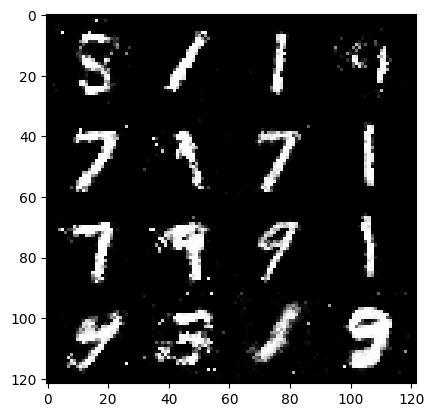

In [18]:
with torch.no_grad():
  z = torch.randn(16,z_dim).to(device)
  sample_imgs = generator(z).cpu()
  grid = np.transpose(utils.make_grid(sample_imgs, nrow=4, normalize=True), (1,2,0))
  plt.imshow(grid)
  plt.show()